#	Model Design and Training , feature extraction


In [1]:
'''
                         Deep Learning Project 
                                    
                    >>  Traffic Sign Recognition  <<         

Date : 29 / 11 / 2024  Friday   2:05 PM   

By : Mohamed Elsayed Farag & Marwan Ahmed Youssef ====> Model design and training.
By : Eyad Mohamed          & Mohamed sobhy        ====> Feature extraction       .          

'''

'\n                         Deep Learning Project \n                                    \n                    >>  Traffic Sign Recognition  <<         \n\nDate : 29 / 11 / 2024  Friday   2:05 PM   \n\nBy : Mohamed Elsayed Farag & Marwan Ahmed Youssef ====> Model design and training.\nBy : Eyad Mohamed          & Mohamed sobhy        ====> Feature extraction       .          \n\n'

# import libs

In [2]:
                                 #=========================libaraies================================


from torch.utils.data import DataLoader                        #helps load and iterate over datasets for training and evaluation in PyTorch.
from skimage.metrics import structural_similarity as ssim            #calculates the structural similarity (SSIM) between two images
from pytorch_fid import fid_score                                              #calculates the Fréchet Inception Distance (FID) score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #provides various classification evaluation metrics
import numpy as np                                           #provides numerical computing tools for working with arrays and matrices.
import torch                                                  #popular deep learning framework for building and training neural networks.
import numpy as np  
import pandas as pd                                           # data analysis and manipulation capabilities
from torch import classes, nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms , models
from PIL import Image
import os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold #====> at feature selection
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# set device

In [3]:
#checks if a CUDA-enabled GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'       
print(device)


cuda


# Transforms

In [4]:
Image_transform = transforms.Compose([
                                     # Resizes the input image to 32 x 32 pixel
    transforms.Resize((32, 32)),
                                    # Randomly rotate images by up to �3�
    transforms.RandomRotation(3),
                                     # HorizontalFilp Image  like   <<< >>>   & Help Prevent overfitting
    transforms.RandomHorizontalFlip(),
                                     # Convert image PIL image or Numpy array To PyTorch Tenser
    transforms.ToTensor(),
                                     # Normalize Pixel Value = Value pixel - Mean / std For each channel < Red * Green * Blue >
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Set Datasets

In [5]:
class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Path to the CSV file
        self.meta_data = pd.read_csv(csv_file)
        # Path to the directory images
        self.root_dir = root_dir
        # Selected dataset transformer
        self.transform = transform

    def __len__(self):
        # Number of entries
        return len(self.meta_data)

    # Index of requested record
    def __getitem__(self, idx):

        # Get image path and bounding box coordinates ===> depend on data
        img_path = os.path.join(self.root_dir, self.meta_data.iloc[idx, 7]) 

        # Convert image To RGB
        image = Image.open(img_path).convert('RGB')

        # Extract sign From image By crop

        # x1 >> Top-left x-axis point
        x1 = self.meta_data.iloc[idx, 2]
        # y1 >> Top-left y-axis point
        y1 = self.meta_data.iloc[idx, 3]
        # x2 >> Bottom-right x-axis point
        x2 = self.meta_data.iloc[idx, 4]
        # y2 >> Bottom-right y-axis point
        y2 = self.meta_data.iloc[idx, 5]

        # crop image based on roi bounding box
        image = image.crop((x1, y1, x2, y2))

        # Get Label
        label = int(self.meta_data.iloc[idx, 6])

        if self.transform:                                                    # Apply transform
            image = self.transform(image)

        return image, label

# Read Datasets

In [6]:
train_dataset = GTSRBDataset(csv_file=r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\data\Train.csv",
                             root_dir=r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\data", transform=Image_transform)

test_dataset = GTSRBDataset(csv_file=r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\data\Test.csv",
                            root_dir=r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\data", transform=Image_transform)


# Split Train dataset to train and validation dataset

In [7]:
# Set 80% of Dataset for Train
train_size = int(0.8 * len(train_dataset))
# Set 20% of Dataset for Validation
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size])   # Applying
len(train_dataset), len(val_dataset), len(test_dataset)

(31367, 7842, 12630)

# Set DataLoader

In [8]:
# Train DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [9]:
root_dir=r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\data"    #Defines the root directory path of the dataset.
imgs_path = os.path.join(root_dir, 'Train')                                    # Constructs the path to the training images directory.
imgs_paths = []                                          # Initializes empty lists to store the paths of images and their corresponding labels.   
labels = []                                             #

for dirs in os.listdir(imgs_path):                                      # return folders
    if dirs not in ['40' , '38','39','41','42']:                        # specific subdirectories from consideration.
      dir_path = os.path.join(imgs_path, dirs)                          #  Constructs the path to the current subdirectory.
      for file in os.listdir(dir_path):                                 #  Iterates through all the  (images) within the current subdirectory.
        imgs_paths.append(os.path.join(dir_path, file))                 #Appends the full path of the current image
        labels.append(dirs)


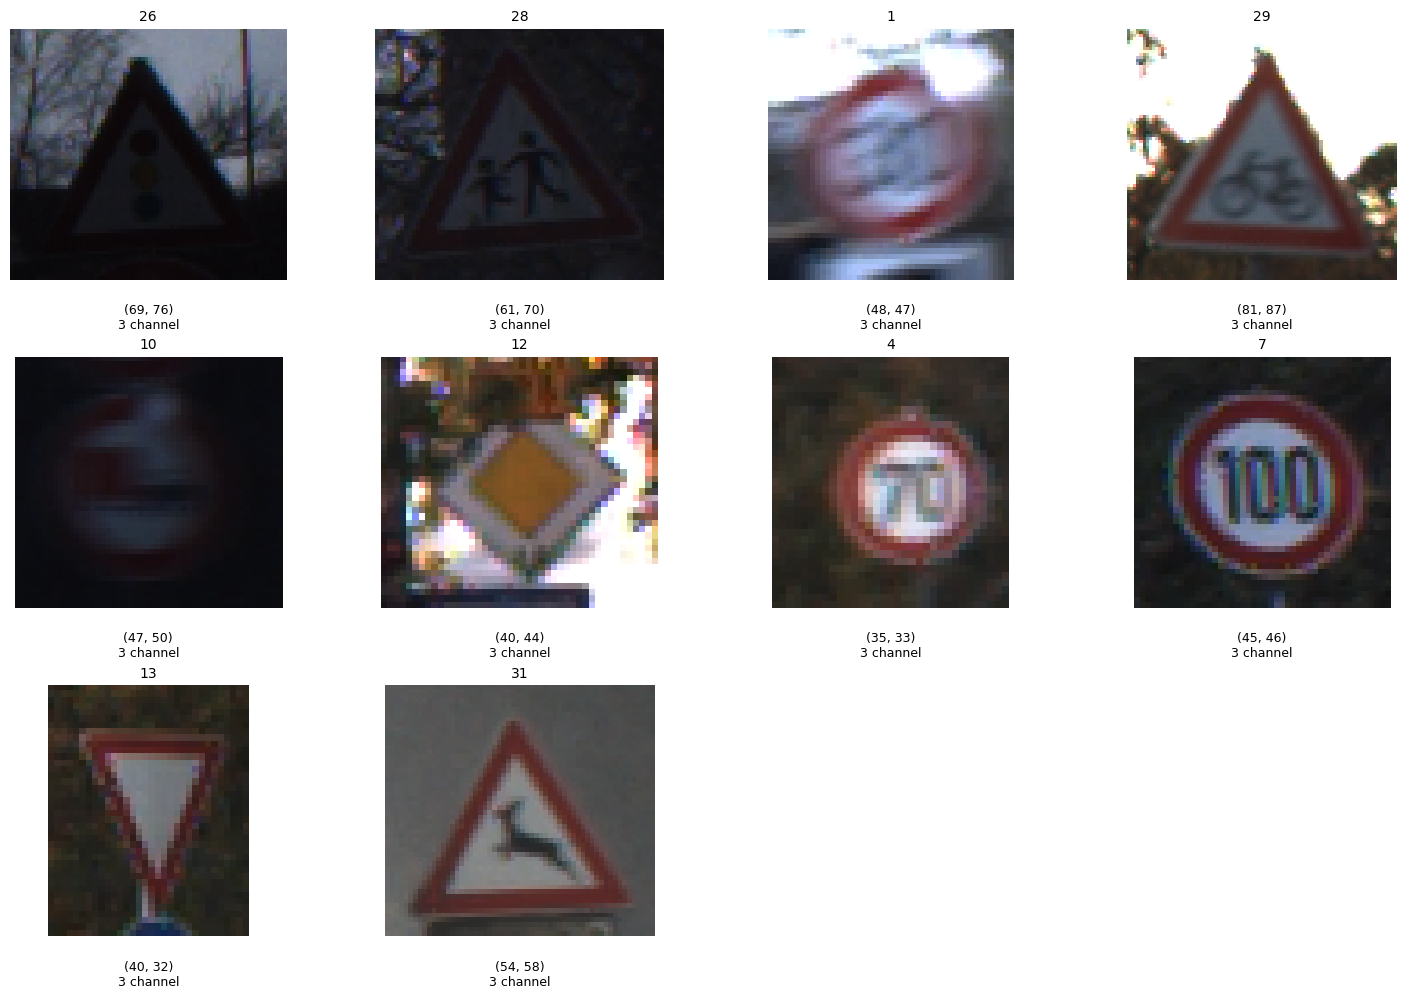

In [10]:
import random
def show_random_images_per_brand(data, labels):
    brand_images = {}

    # Ensure we don't sample more than the available number of images

    # Collect up to 12 random images (avoiding duplicates for the same brand)
    sampled_pairs = random.sample(list(zip(data, labels)), 12)

    for file, label in sampled_pairs:
        if label not in brand_images:
            brand_images[label] = file

    # Display images
    plt.figure(figsize=(15, 10))
    num_brands = len(brand_images)

    for i, (brand, data) in enumerate(brand_images.items()):
        if type(data) == str:
            img = mpimg.imread(data)  # If it's a file path, read the image
        else:
            img = data  # If it's already image data, just assign it

        plt.subplot((num_brands // 4) + 1, 4, i + 1)  # Display in a grid with up to 4 columns
        plt.imshow(img, cmap=plt.cm.binary)
        plt.title(brand, fontsize=10)

        # Get image dimensions and channels
        shape_str = str(img.shape[:-1])  # e.g., (256, 256)
        shape_with_channel = f"{img.shape[-1]} channel"  # e.g., 3 channel

        # Add the label below the image using plt.text()
        plt.text(0.5, -0.15, f"{shape_str}\n{shape_with_channel}", fontsize=9, ha='center', va='center', transform=plt.gca().transAxes)

        plt.axis('off')  # Hide axes for better visualization

    plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing between subplots
    plt.tight_layout()
    plt.show()
show_random_images_per_brand(imgs_paths, labels)

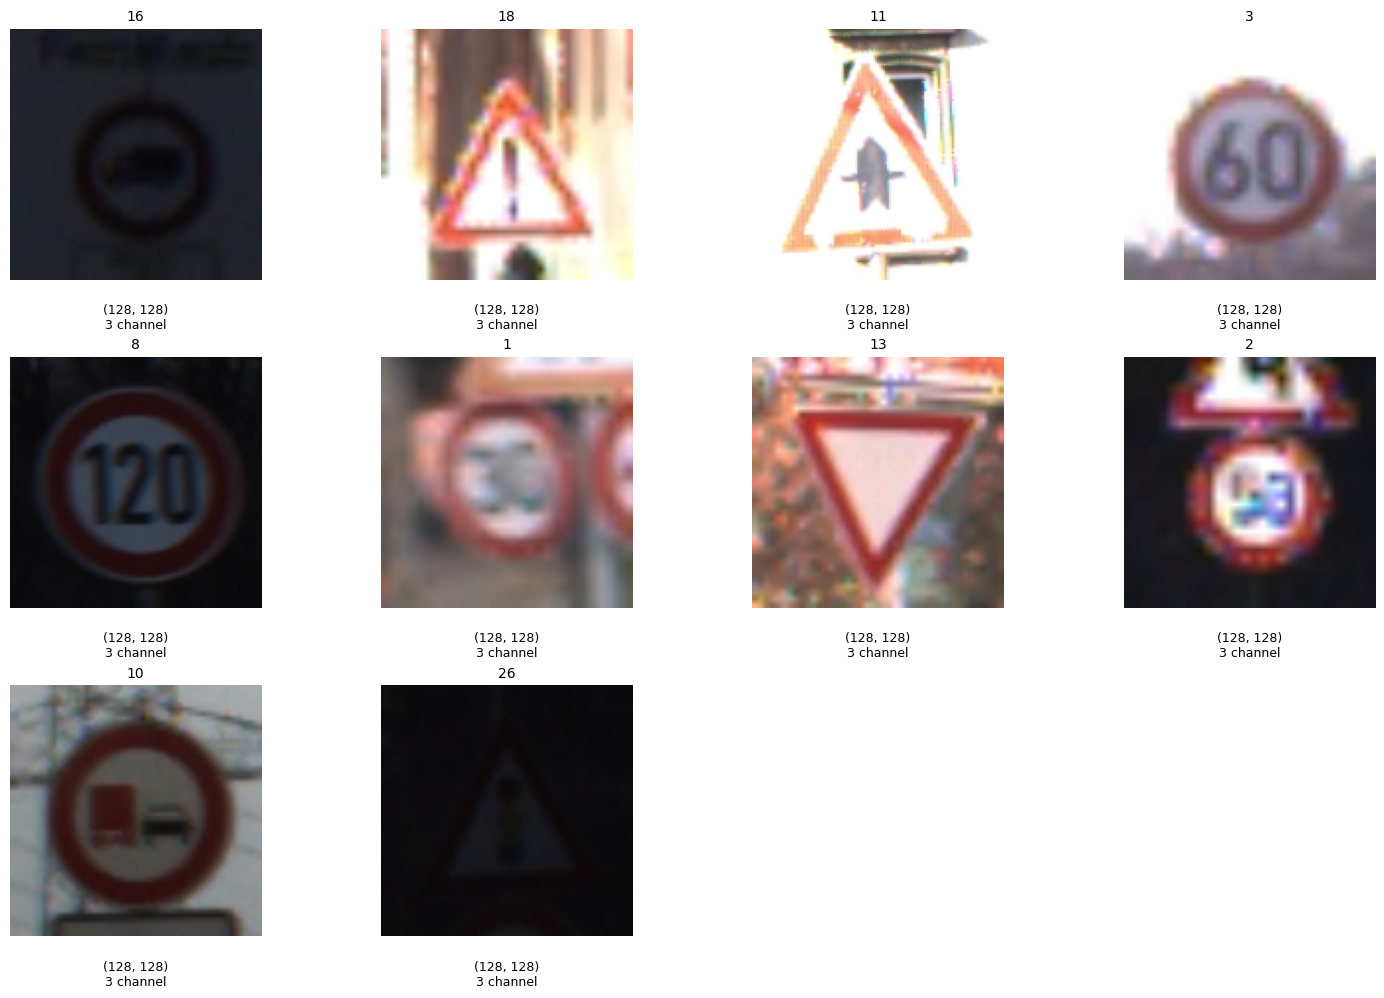

In [11]:
import cv2
import numpy as np

new_data = []                                                               # Initializes an empty list to store the processed images.

for img_file in imgs_paths:                                                 #Iterates through the list of image paths.
    image = cv2.imread(img_file)                                            # Reads the image from the file path using OpenCV.
    if image is None:
        print(f"Warning: Unable to read {img_file}")
        continue
    image = cv2.resize(image, (128, 128))                                   #Resizes the image to a fixed size of 128x128 pixels.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                          # Converts the image from BGR color space to RGB color space
    image = np.array(image)
    new_data.append(image)

show_random_images_per_brand(new_data, labels)

VISUALIZATION


In [12]:
def visualize_data(data_loader):
    images, labels = next(iter(data_loader))

    # Set up a 4x4 grid for subplots
    fig, axes = plt.subplots(4, 4, figsize=(8,8))

    for i in range(16):
        ax = axes[i // 4, i % 4]
        img = images[i].numpy()                # Convert the image tensor to a numpy array
        img = np.transpose(img, (1, 2, 0))     # Change shape from [C, H, W] to [H, W, C]
        img = img * 0.5 + 0.5                  # Reverse the normalization

        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')                         # Hide the axis

    plt.tight_layout()                         # Adjust layout to prevent overlap
    plt.show()

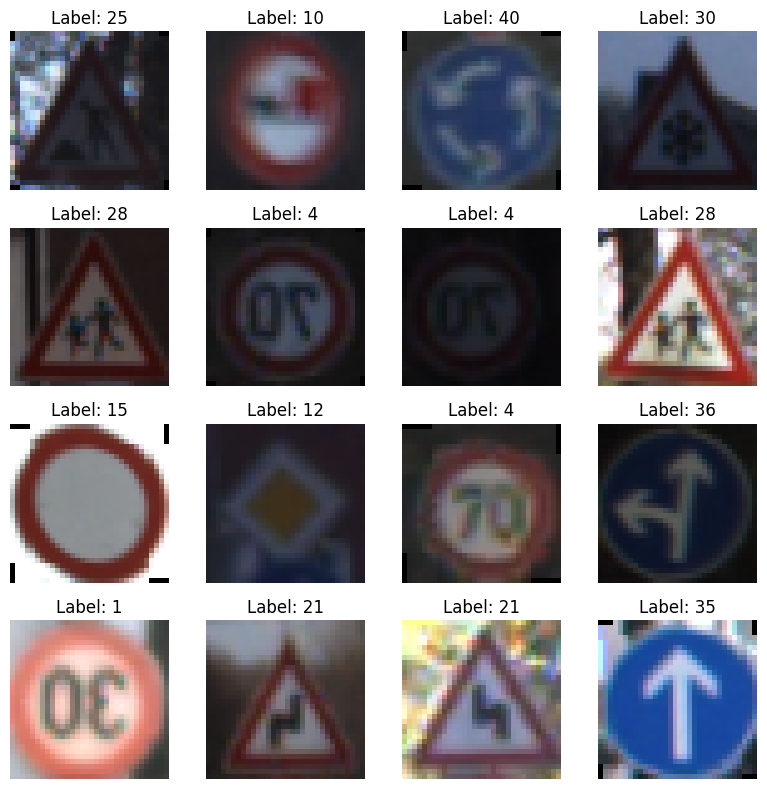

In [13]:
# visualize train data
visualize_data(train_loader)

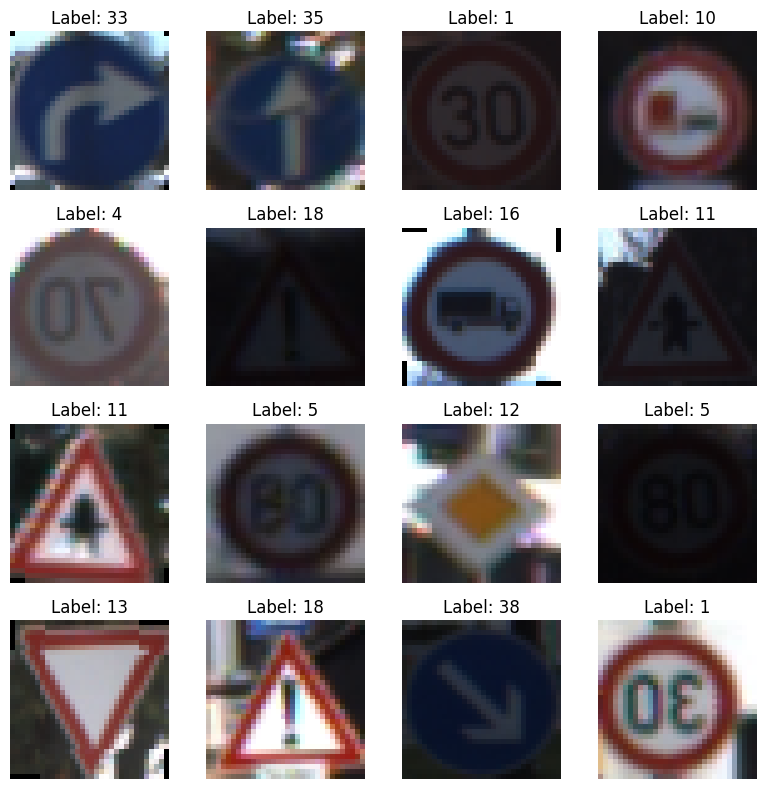

In [14]:
visualize_data(val_loader)

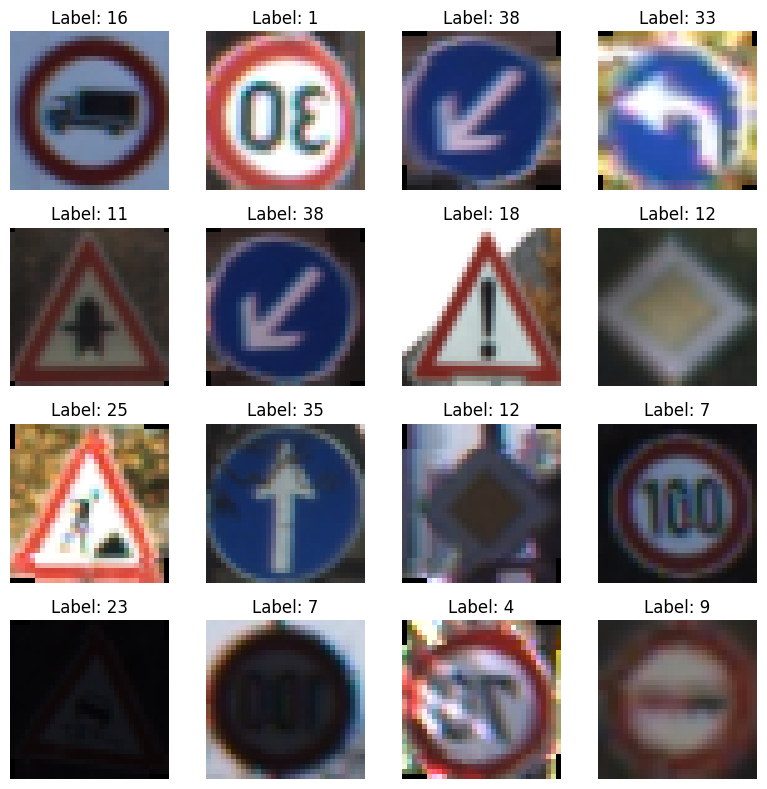

In [15]:
visualize_data(test_loader)

In [20]:
import cv2
import numpy as np

# Function for noise removal
def noise_removal(image):

    # 1. Remove noise using Gaussian Filter
    denoised_gaussian = cv2.GaussianBlur(image, (5, 5), 0)

    # 2. Remove noise using Median Filter
    denoised_median = cv2.medianBlur(denoised_gaussian, 5)

    # Return the final denoised image
    return denoised_median

# Function to process a list of images (new_data) and return processed images
def process_images(new_data):

    processed_images = []

    # Loop through each image in new_data
    for img in new_data:
        # Apply noise removal
        denoised_image = noise_removal(img)

        # Append the denoised image to the list
        processed_images.append(denoised_image)

    return processed_images

# Process new data and apply noise removal
data_noise_removal = process_images(new_data)


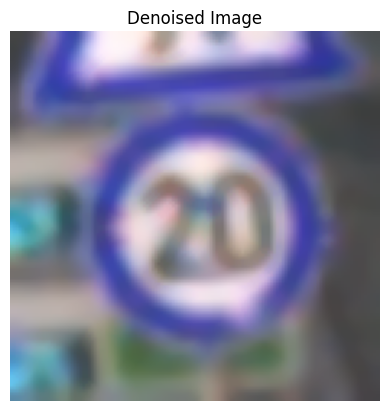

In [19]:
image_to_show = data_noise_removal[5]
if not isinstance(image_to_show, np.ndarray):
    raise ValueError("The image format is incorrect.")

# Display the image
plt.imshow(cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.axis('off')  # Remove axis
plt.title("Old image")  # Add a title for context
plt.show()  # Render the image

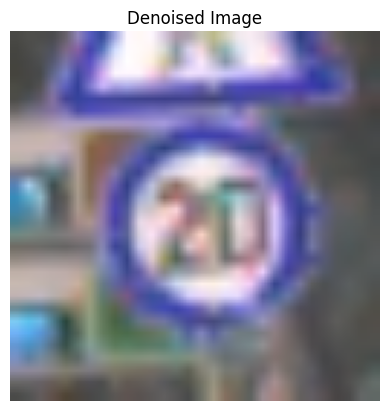

In [ ]:
image_to_show = new_data[1]

if not isinstance(image_to_show, np.ndarray):
    raise ValueError("The image format is incorrect.")

# Display the image
plt.imshow(cv2.cvtColor(image_to_show, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
plt.axis('off')  # Remove axis
plt.title("New data")  # Add a title for context
plt.show()  # Render the image

# Classifier 



In [21]:

# Inherits  Neural Network Modul
class GTSRBClassifier(nn.Module):
    def __init__(self):
        super(GTSRBClassifier, self).__init__()
        self.model = nn.Sequential(

            # First Layer

            # Input => 3 channels *RGB*     Output => 32 Feature map    Filter => 3x3   Padding => 1
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, padding=1),
            # Activation Function ReLU(0,piexel_Value)
            nn.ReLU(),
            # MaxPool2d For Downsample and Reduce dimensions of feature map 2x2 filter & stride like filter & padding Defult = 0 & Dialtion Defult = 1
            nn.MaxPool2d(kernel_size=2),

            # Second layer

            # Input => 23 channels *RGB*     Output => 64 Feature map    Filter => 3x3   Padding => 1
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, padding=1),
            # Activation Function ReLU(0,piexel_Value)
            nn.ReLU(),
            # MaxPool2d For Downsample and Reduce dimensions of feature map 2x2 filter & stride like filter & padding Defult = 0 & Dialtion Defult = 1
            nn.MaxPool2d(kernel_size=2),


            # Third layer

            # Input => 64 channels *RGB*     Output => 128 Feature map    Filter => 3x3   Padding => 1
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            # Activation Function ReLU(0,piexel_Value)
            nn.ReLU(),

            # After Third layer output feature map is Flattenet and Fed into two fully connected layers

            # Flatten and apply linear

            # Flatten input tensor to 1D *vector* like (batch_size, 128, 8, 8) => (batch_size, 128 * 8 * 8)
            nn.Flatten(),
            # First Fully connected layer *dense layer*  input =>  128 feature map * 8 height * 8 width output 256 feature *Number of neurons*
            nn.Linear(in_features=128*8*8, out_features=256),
            # Activation Function ReLU(0,piexel_Value)
            nn.ReLU(),
            # Input 256 Feature map output 43 Traffic sign
            nn.Linear(in_features=256, out_features=43)
        )

    def forward(self, x):
        # Forwarding
        return self.model(x)


# Greate Model From Class

model = GTSRBClassifier().to(device)

# optimizer and loss function

In [22]:
# pretrained model
model = models.resnet18(pretrained=True)

# 
num_classes = 43    # number of traffic signs
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer to updata Weights and Baises During training
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function give Error for Model => Predicted - actual
loss_fn = nn.CrossEntropyLoss()

# Create scheduler  adjust the learning rate during training => improve the efficiency and effectiveness of the training process <=
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Improves Convergence &  Avoid Overshooting &  Prevents Overfitting
# Parameters { optimizer *control Learning rate* & step_size *Number of epoch to adjust lr * & gamma *  0.1 * lr * }

c:\Users\Mahmoud Salman\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mahmoud Salman\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Traning

In [23]:
def train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # List to store the average training loss for each epoch.
    training_loss = []
    # List stores the average validation loss.
    validation_loss = []

    for epoch in range(epochs):
        # Initializes variable accumulate  total training loss for the current epoch.
        train_loss = 0.0
        # Initializes variable accumulate  total Validation loss for the current epoch
        val_loss = 0.0

        # Set model to traning mode
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(
                device)  # Move data to GPU

            # Sets gradients to zero before each batch, preparing for backpropagation
            optimizer.zero_grad()

            # forward pass
            # Forward image pass through the model to get predictions for the current batch of images.
            output = model(images)
            # Calculates the loss using the loss function > Prediction - actual <
            loss = loss_fn(output, labels)

            # Backpropagation
            # Calculating the gradients of the loss
            loss.backward()
            # Updates the model's parameters Using gradients using optimizer to reduce future loss.
            optimizer.step()

            # Total train_loss
            # Sum Current batch train_loss to the total loss
            train_loss += loss.item()

        # Model evaluation
        # Set model to the Evaluation mode  including disable optimizer for more stable evaluation
        model.eval()

        # Using no_grad / inference
        # Disable gradiant calculator during validation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(
                    device)                           # Move data to Device
                # Forward pass to get predictions
                output = model(images)
                # Calculates the loss using the loss function > Prediction - actual <
                loss = loss_fn(output, labels)
                # Sum Current batch val_loss to the total loss
                val_loss += loss.item()

        # Calculate avg loss
        train_loss /= len(train_loader)
        # Calculate avg loss
        val_loss /= len(val_loader)

        # Append data
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

        # print loss per epoch
        print(
            f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

        # Step the scheduler if defined
        if scheduler:
            scheduler.step()

    return training_loss, validation_loss

training_loss, validation_loss = train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=5)



Epoch 1/5 - Training Loss: 0.5521 - Validation Loss: 0.2622
Epoch 2/5 - Training Loss: 0.1741 - Validation Loss: 0.1248
Epoch 3/5 - Training Loss: 0.1230 - Validation Loss: 0.1520
Epoch 4/5 - Training Loss: 0.0953 - Validation Loss: 0.0608
Epoch 5/5 - Training Loss: 0.0867 - Validation Loss: 0.1049


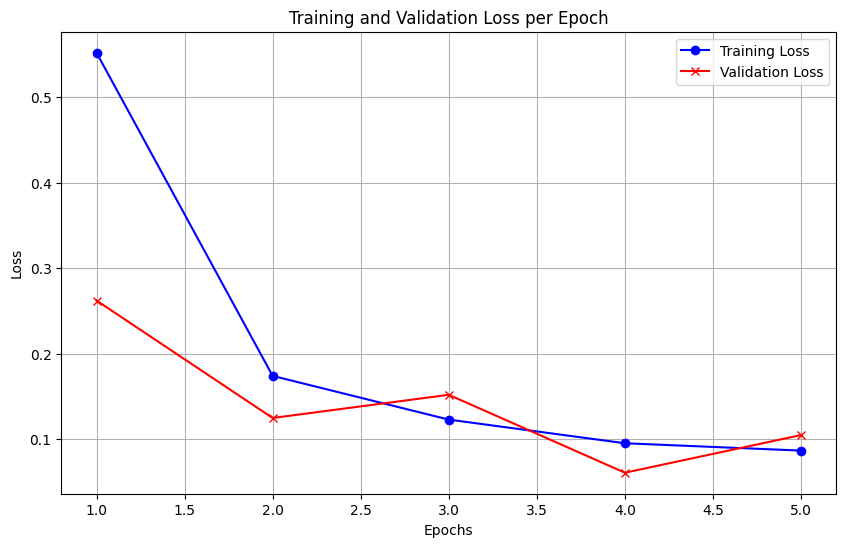

In [24]:
def plot_losses(training_loss, validation_loss):
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(range(1, len(training_loss) + 1), training_loss, label='Training Loss', color='blue', marker='o')
    
    # Plot validation loss
    plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss', color='red', marker='x')
    
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the losses
plot_losses(training_loss, validation_loss)


# Testing (evluation) Model

In [25]:
def Testing(model, test_loader, real_images=None, generated_images=None):
    # Move model to the right device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)

            test_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate classification metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    # Weighted average for multi-class problems
    precision = precision_score(
        test_labels, predicted_labels, average='weighted')
    recall = recall_score(test_labels, predicted_labels, average='weighted')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # FID and SSIM calculations (only for generative models)
    fid_value = None
    ssim_value = None
    if real_images is not None and generated_images is not None:
        # FID Score Calculation
        fid_value = fid_score.calculate_fid_given_paths(
            [real_images, generated_images], batch_size=50, device=device, dims=2048)
        print(f"FID Score: {fid_value}")

        # SSIM Calculation (assuming the images are single-channel grayscale for simplicity)
        # If you have RGB images, you need to convert them to grayscale or use SSIM for each channel.
        ssim_value = ssim(real_images, generated_images,
                          data_range=generated_images.max() - generated_images.min())
        print(f"SSIM: {ssim_value:.4f}")

    return test_labels, predicted_labels, accuracy, precision, recall, f1, fid_value, ssim_value

# Example usage
# Assuming `model` is your trained model and `test_loader` is your test DataLoader
# If you are working with generative images, you need to pass `real_images` and `generated_images` as well.

# Example DataLoader
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# If you are testing a classification model
test_labels, predicted_labels, accuracy, precision, recall, f1, fid, ssim = Testing(
    model, test_loader)

# If you have real and generated images, provide them for FID and SSIM calculation
# real_images = torch.randn(batch_size, 3, 256, 256)  # Example real images tensor
# generated_images = torch.randn(batch_size, 3, 256, 256)  # Example generated images tensor


Accuracy: 0.9040
Precision: 0.9256
Recall: 0.9040
F1-Score: 0.9091


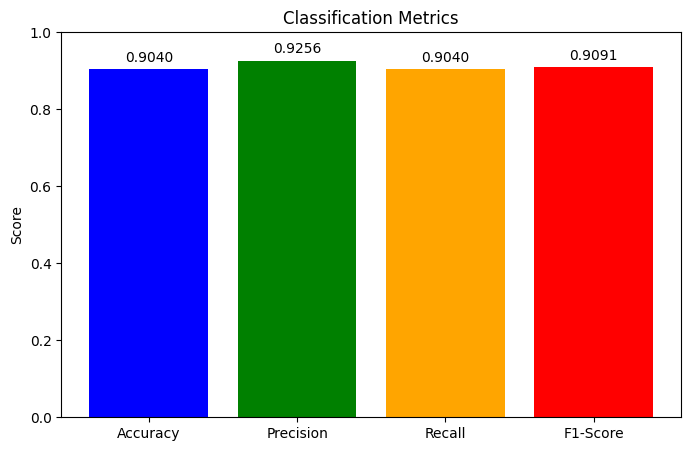

In [26]:
def visualize_testing_results(accuracy, precision, recall, f1, fid=None, ssim=None):
 
    # Classification metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    scores = [accuracy, precision, recall, f1]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
    plt.ylim(0, 1)  # Metrics are normalized between 0 and 1
    plt.title('Classification Metrics')
    plt.ylabel('Score')
    for i, v in enumerate(scores):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)
    plt.show()

    # Generative metrics (if applicable)
    if fid is not None and ssim is not None:
        plt.figure(figsize=(8, 5))
        generative_metrics = ['FID', 'SSIM']
        generative_scores = [fid, ssim]

        plt.bar(generative_metrics, generative_scores, color=['purple', 'cyan'])
        plt.title('Generative Model Metrics')
        plt.ylabel('Score')
        for i, v in enumerate(generative_scores):
            plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)
        plt.show()

# Call the visualization function
visualize_testing_results(accuracy, precision, recall, f1, fid, ssim)


# cross validation

In [27]:
from sklearn.model_selection import KFold

def cross_validation(dataset, model_class, k=5, epochs=4):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    # Iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        # Create subsets for training and validation
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        # Create dataloaders for each fold
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # Initialize a new model for each fold
        model = model_class().to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()

        # Train the model for the current fold
        training_loss, validation_loss = train(model, train_loader, val_loader, optimizer, loss_fn, None, epochs)

        # Evaluate the model on validation set
        val_labels, val_preds, accuracy, precision, recall, f1, _, _ = Testing(model, val_loader)

        # Store results for this fold
        fold_results.append({
            "fold": fold + 1,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        })

        print(f"Fold {fold + 1} Results: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")

    # Aggregate and display overall results
    overall_results = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1_score": np.mean([result["f1_score"] for result in fold_results]),
    }

    print("Overall Cross-Validation Results:")
    print(f"Accuracy: {overall_results['accuracy']:.4f}")
    print(f"Precision: {overall_results['precision']:.4f}")
    print(f"Recall: {overall_results['recall']:.4f}")
    print(f"F1-Score: {overall_results['f1_score']:.4f}")

    return fold_results, overall_results

# Example usage of cross-validation
# Combine training and validation datasets for cross-validation
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Run cross-validation
results, overall = cross_validation(full_dataset, GTSRBClassifier, k=5, epochs=4)

Fold 1/5
Epoch 1/4 - Training Loss: 1.0567 - Validation Loss: 0.3648
Epoch 2/4 - Training Loss: 0.2120 - Validation Loss: 0.1546
Epoch 3/4 - Training Loss: 0.1110 - Validation Loss: 0.1024
Epoch 4/4 - Training Loss: 0.0755 - Validation Loss: 0.1168
Accuracy: 0.9647
Precision: 0.9668
Recall: 0.9647
F1-Score: 0.9645
Fold 1 Results: Accuracy: 0.9647, Precision: 0.9668, Recall: 0.9647, F1-Score: 0.9645

Fold 2/5
Epoch 1/4 - Training Loss: 0.9216 - Validation Loss: 0.2633
Epoch 2/4 - Training Loss: 0.1709 - Validation Loss: 0.1363
Epoch 3/4 - Training Loss: 0.0999 - Validation Loss: 0.1312
Epoch 4/4 - Training Loss: 0.0594 - Validation Loss: 0.0877
Accuracy: 0.9764
Precision: 0.9768
Recall: 0.9764
F1-Score: 0.9762
Fold 2 Results: Accuracy: 0.9764, Precision: 0.9768, Recall: 0.9764, F1-Score: 0.9762

Fold 3/5
Epoch 1/4 - Training Loss: 1.0213 - Validation Loss: 0.2750
Epoch 2/4 - Training Loss: 0.1892 - Validation Loss: 0.1544
Epoch 3/4 - Training Loss: 0.1046 - Validation Loss: 0.1107
Epoch

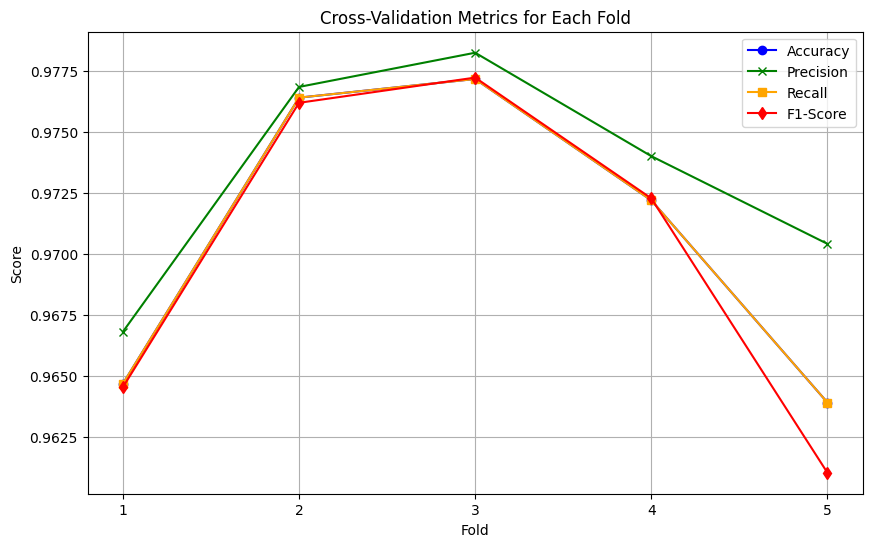

In [28]:
def visualize_folds(fold_results):
    # Extract metrics
    folds = [result['fold'] for result in fold_results]
    accuracies = [result['accuracy'] for result in fold_results]
    precisions = [result['precision'] for result in fold_results]
    recalls = [result['recall'] for result in fold_results]
    f1_scores = [result['f1_score'] for result in fold_results]

    # Plot metrics for each fold
    plt.figure(figsize=(10, 6))

    plt.plot(folds, accuracies, label='Accuracy', marker='o', color='blue')
    plt.plot(folds, precisions, label='Precision', marker='x', color='green')
    plt.plot(folds, recalls, label='Recall', marker='s', color='orange')
    plt.plot(folds, f1_scores, label='F1-Score', marker='d', color='red')

    plt.title('Cross-Validation Metrics for Each Fold')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(folds)  # Set x-axis to fold numbers
    plt.legend()
    plt.grid(True)
    plt.show()


visualize_folds(results)


Accuracy: 0.9039588281868567
F1 Score: 0.9090810733533444
Precision: 0.9256167434604479
Recall: 0.9039588281868567
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.93      0.97      0.95       720
           2       0.91      0.98      0.94       750
           3       0.94      0.97      0.96       450
           4       0.97      0.97      0.97       660
           5       0.83      0.85      0.84       630
           6       0.98      0.80      0.88       150
           7       0.99      0.77      0.86       450
           8       0.94      0.92      0.93       450
           9       0.97      0.99      0.98       480
          10       0.98      0.99      0.99       660
          11       0.95      0.93      0.94       420
          12       1.00      0.88      0.93       690
          13       1.00      0.99      0.99       720
          14       1.00      0.99      0.99       2

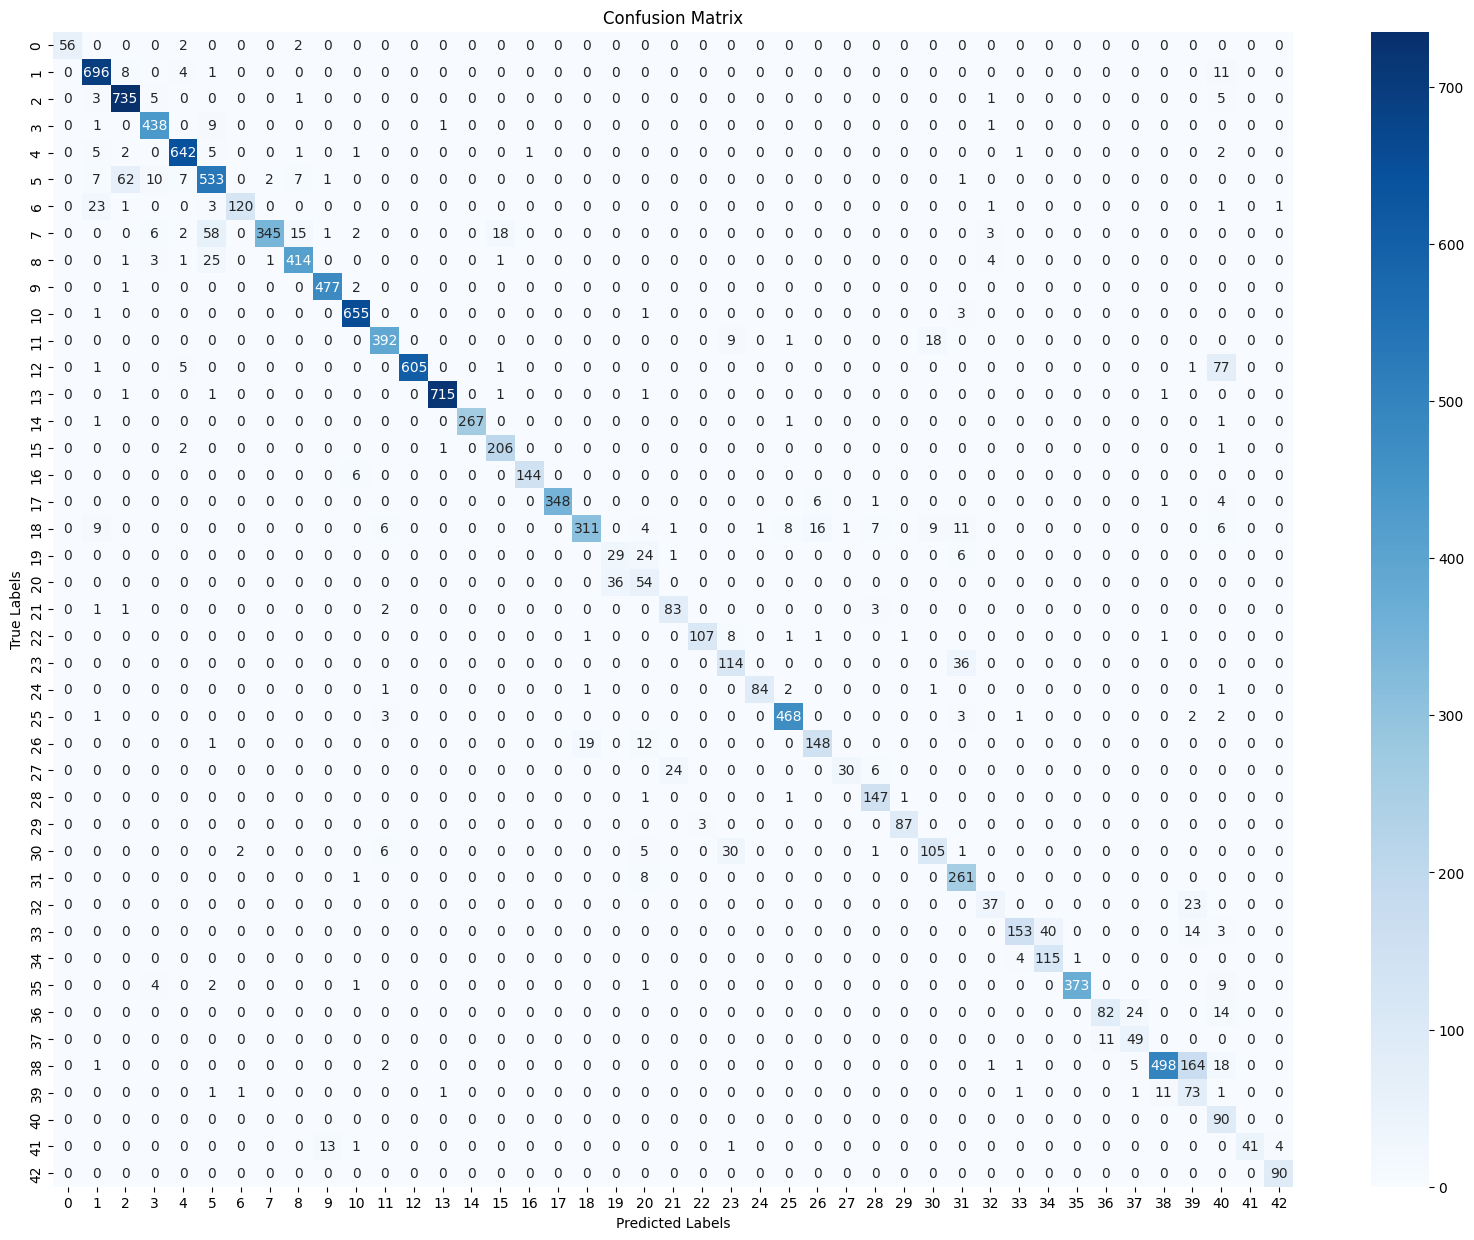

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score, recall_score

# print accuracy , f1score ,precision scre ,recall score
print("Accuracy:", accuracy_score(test_labels, predicted_labels))
print("F1 Score:", f1_score(test_labels, predicted_labels, average='weighted'))
print("Precision:", precision_score(test_labels, predicted_labels, average='weighted'))
print("Recall:", recall_score(test_labels, predicted_labels, average='weighted'))

# print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))


# visualize confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# plot real labels
plt.figure(figsize=(20, 15))  # Set figure size to 20x15
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(len(cm[0]))], yticklabels=[str(i) for i in range(len(cm))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
#export model
torch.save(model.state_dict(), r"C:\Users\Mahmoud Salman\Downloads\Telegram Desktop\data (2)\GTSRB_model_weights.pth")
print("Model has been saved successfully.")

Model has been saved successfully.
